# General API quickstart

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.9.0
Running on ArviZ v0.8.3


## 1. Model creation

Models in PyMC3 are centered around the `Model` class. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a `with` context:

In [3]:
with pm.Model() as model:
    # Model definition
    pass

We discuss RVs further below but let's create a simple model to explore the `Model` class.

In [4]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

In [5]:
model.basic_RVs

[mu, obs]

In [6]:
model.free_RVs

[mu]

In [7]:
model.observed_RVs

[obs]

In [8]:
model.logp({"mu": 0})

array(-133.32892343)

It's worth highlighting the design choice we made with `logp`.  As you can see above, `logp` is being called with arguments, so it's a method of the model instance. More precisely, it puts together a function based on the current state of the model -- or on the state given as argument to `logp` (see example below).

For diverse reasons, we assume that a `Model` instance isn't static. If you need to use `logp` in an inner loop and it needs to be static, simply use something like `logp = model.logp`. Here is an example below -- note the caching effect and the speed up:

In [9]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

116 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.4 µs ± 649 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## 2. Probability Distributions

Every probabilistic program consists of observed and unobserved Random Variables (RVs). Observed RVs are defined via likelihood distributions, while unobserved RVs are defined via prior distributions. In PyMC3, probability distributions are available from the main module space:

In [10]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In the PyMC3 module, the structure for probability distributions looks like this:

[pymc3.distributions](../api/distributions.rst)
- [continuous](../api/distributions/continuous.rst)
- [discrete](../api/distributions/discrete.rst)
- [timeseries](../api/distributions/timeseries.rst)
- [mixture](../api/distributions/mixture.rst)


In [11]:
dir(pm.distributions.mixture)

['Discrete',
 'Distribution',
 'Iterable',
 'Mixture',
 'Normal',
 'NormalMixture',
 '_DrawValuesContext',
 '_DrawValuesContextBlocker',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_conversion_map',
 'all_discrete',
 'bound',
 'broadcast_distribution_samples',
 'draw_values',
 'generate_samples',
 'get_tau_sigma',
 'get_variable_name',
 'logsumexp',
 'np',
 'random_choice',
 'theano',
 'to_tuple',
 'tt',
 'warnings']

### Unobserved Random Variables

Every unobserved RV has the following calling signature: name (str), parameter keyword arguments. Thus, a normal prior can be defined in a model context like this:

In [12]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

As with the model, we can evaluate its logp:

In [13]:
x.logp({"x": 0})

array(-0.91893853)

### Observed Random Variables

Observed RVs are defined just like unobserved RVs but require data to be passed into the `observed` keyword argument:

In [14]:
with pm.Model():
    obs = pm.Normal("x", mu=0, sigma=1, observed=np.random.randn(100))

`observed` supports lists, `numpy.ndarray`, `theano` and `pandas` data structures.

### Deterministic transforms

PyMC3 allows you to freely do algebra with RVs in all kinds of ways:

In [15]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

While these transformations work seamlessly, their results are not stored automatically. Thus, if you want to keep track of a transformed variable, you have to use `pm.Deterministic`:

In [16]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

Note that `plus_2` can be used in the identical way to above, we only tell PyMC3 to keep track of this RV for us.

### Automatic transforms of bounded RVs

In order to sample models more efficiently, PyMC3 automatically transforms bounded RVs to be unbounded.

In [17]:
with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1)

When we look at the RVs of the model, we would expect to find `x` there, however:

In [18]:
model.free_RVs

[x_interval__]

`x_interval__` represents `x` transformed to accept parameter values between -inf and +inf. In the case of an upper and a lower bound, a `LogOdd`s transform is applied. Sampling in this transformed space makes it easier for the sampler. PyMC3 also keeps track of the non-transformed, bounded parameters. These are common determinstics (see above): 

In [19]:
model.deterministics

[x]

When displaying results, PyMC3 will usually hide transformed parameters. You can pass the `include_transformed=True` parameter to many functions to see the transformed parameters that are used for sampling.

You can also turn transforms off:

In [20]:
with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1, transform=None)

print(model.free_RVs)

[x]


Or specify different transformation other than the default:

In [21]:
import pymc3.distributions.transforms as tr

with pm.Model() as model:
    # use the default log transformation
    x1 = pm.Gamma("x1", alpha=1, beta=1)
    # specify a different transformation
    x2 = pm.Gamma("x2", alpha=1, beta=1, transform=tr.log_exp_m1)

print("The default transformation of x1 is: " + x1.transformation.name)
print("The user specified transformation of x2 is: " + x2.transformation.name)

The default transformation of x1 is: log
The user specified transformation of x2 is: log_exp_m1


### Transformed distributions and changes of variables
PyMC3 does not provide explicit functionality to transform one distribution to another. Instead, a dedicated distribution is usually created in consideration of optimising performance. However, users can still create transformed distribution by passing the inverse transformation to `transform` kwarg. Take the classical textbook example of LogNormal: $log(y) \sim \text{Normal}(\mu, \sigma)$

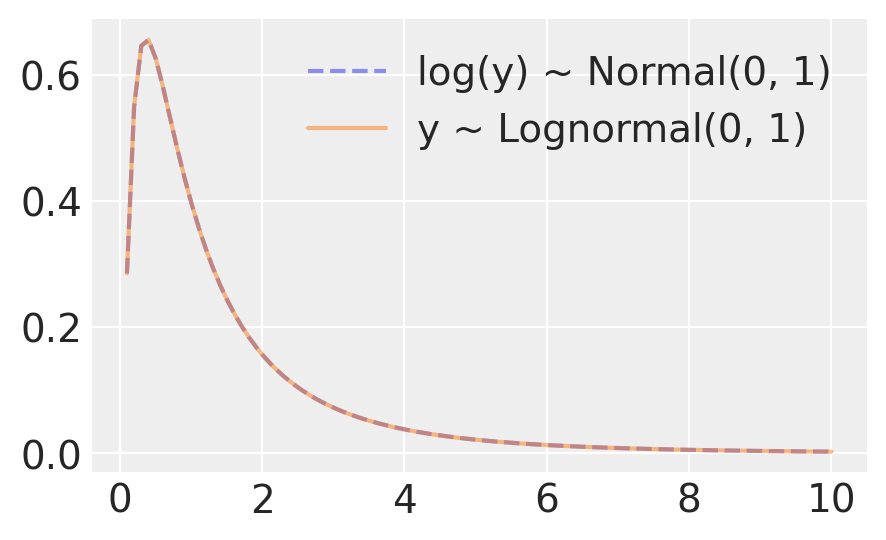

In [22]:
class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)


with pm.Model() as model:
    x1 = pm.Normal("x1", 0.0, 1.0, transform=Exp())
    x2 = pm.Lognormal("x2", 0.0, 1.0)

lognorm1 = model.named_vars["x1_exp__"]
lognorm2 = model.named_vars["x2"]

_, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(0.0, 10.0, 100)
ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    "--",
    alpha=0.5,
    label="log(y) ~ Normal(0, 1)",
)
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha=0.5,
    label="y ~ Lognormal(0, 1)",
)
plt.legend();

Notice from above that the named variable `x1_exp__` in the `model` is Lognormal distributed.  
Using similar approach, we can create ordered RVs following some distribution. For example, we can combine the `ordered` transformation and `logodds` transformation using `Chain` to create a 2D RV that satisfy $x_1, x_2 \sim \text{Uniform}(0, 1) \space and \space x_1< x_2$

In [23]:
Order = tr.Ordered()
Logodd = tr.LogOdds()
chain_tran = tr.Chain([Logodd, Order])

with pm.Model() as m0:
    x = pm.Uniform("x", 0.0, 1.0, shape=2, transform=chain_tran, testval=[0.1, 0.9])
    trace = pm.sample(5000, tune=1000, progressbar=False, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


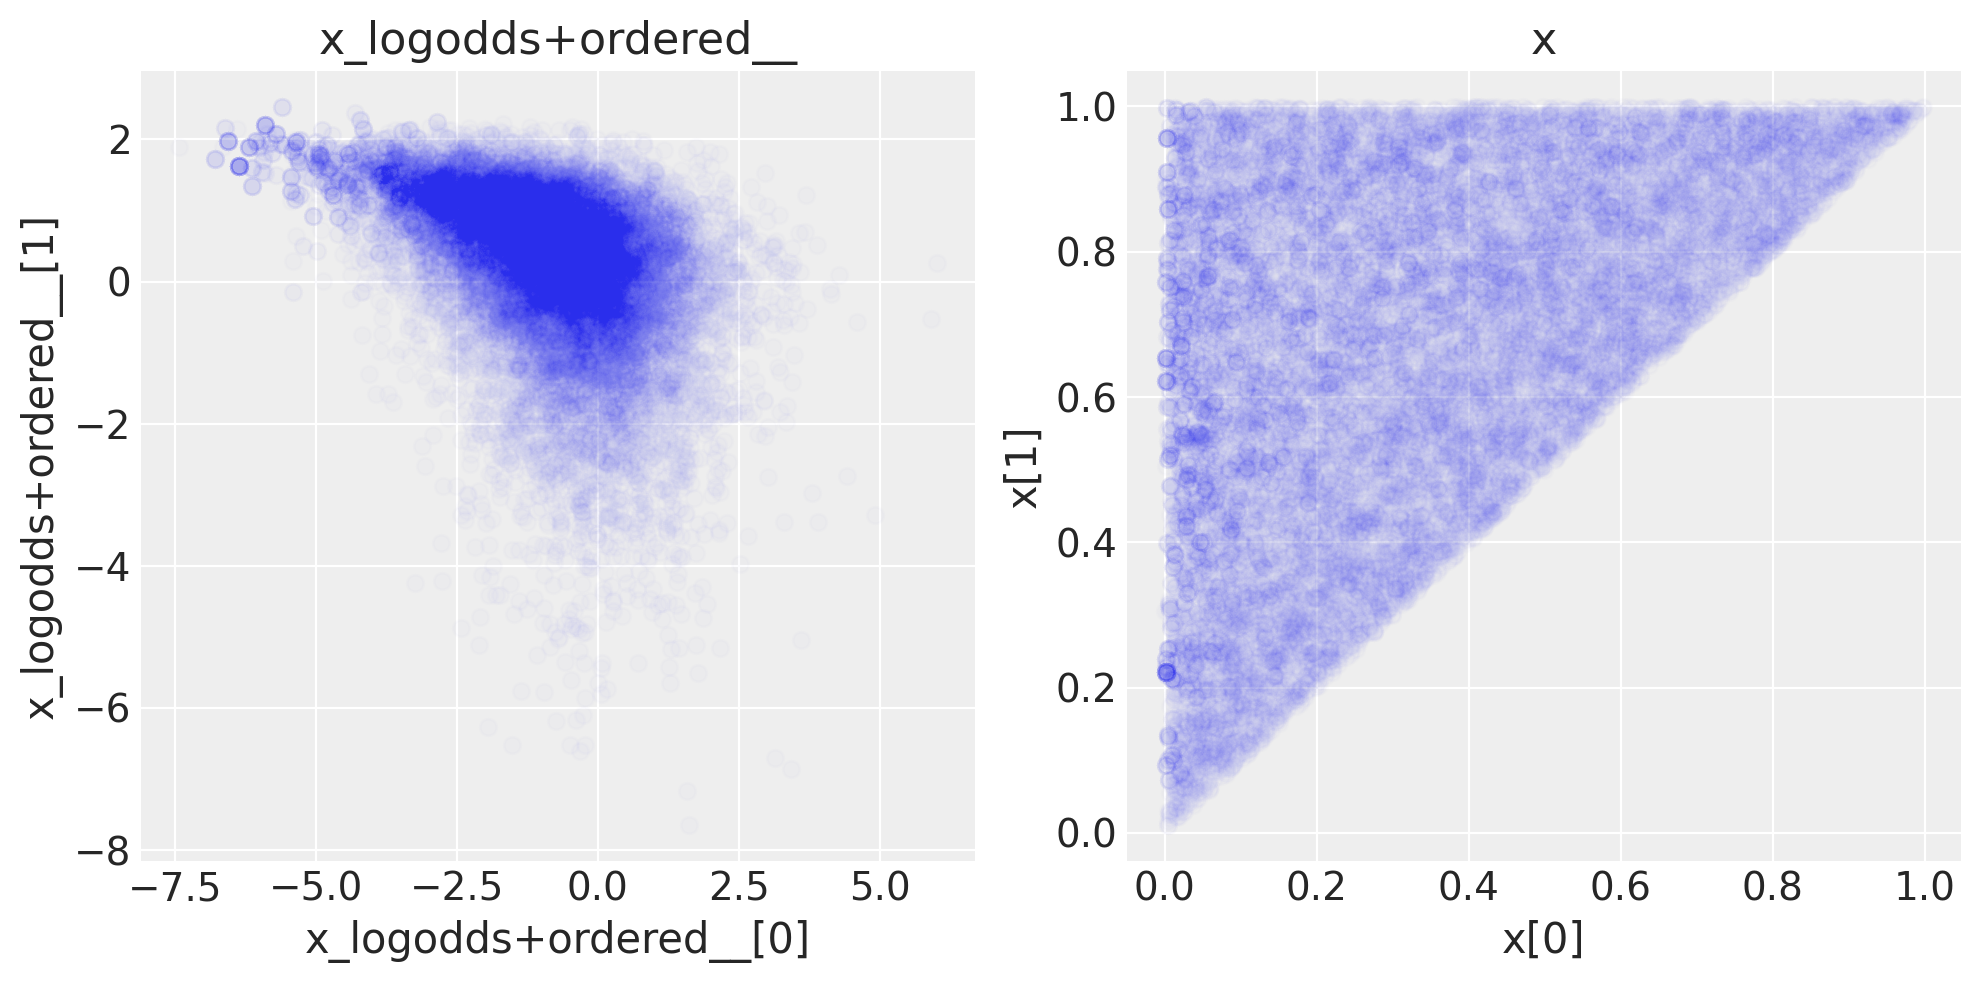

In [24]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(trace.varnames):
    ax[ivar].scatter(trace[varname][:, 0], trace[varname][:, 1], alpha=0.01)
    ax[ivar].set_xlabel(varname + "[0]")
    ax[ivar].set_ylabel(varname + "[1]")
    ax[ivar].set_title(varname)
plt.tight_layout()

### Lists of RVs / higher-dimensional RVs

Above we have seen how to create scalar RVs. In many models, you want multiple RVs. There is a tendency (mainly inherited from PyMC 2.x) to create list of RVs, like this:

In [25]:
with pm.Model():
    # bad:
    x = [pm.Normal("x_{}".format(i), mu=0, sigma=1) for i in range(10)]

However, even though this works it is quite slow and not recommended. Instead, use the `shape` kwarg:

In [26]:
with pm.Model() as model:
    # good:
    x = pm.Normal("x", mu=0, sigma=1, shape=10)

`x` is now a random vector of length 10. We can index into it or do linear algebra operations on it:

In [27]:
with model:
    y = x[0] * x[1]  # full indexing is supported
    x.dot(x.T)  # Linear algebra is supported

### Initialization with test_values

While PyMC3 tries to automatically initialize models it is sometimes helpful to define initial values for RVs. This can be done via the `testval` kwarg:

In [28]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, shape=5)

x.tag.test_value

array([0., 0., 0., 0., 0.])

In [29]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, shape=5, testval=np.random.randn(5))

x.tag.test_value

array([-1.33542817,  0.5065966 , -0.57362379, -0.01840329,  0.31782327])

This technique is quite useful to identify problems with model specification or initialization.

## 3. Inference

Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: sampling and variational inference.

### 3.1 Sampling

The main entry point to MCMC sampling algorithms is via the `pm.sample()` function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don't pass anything.

With PyMC3 version >=3.9 the `return_inferencedata=True` kwarg makes the `sample` function return an `arviz.InferenceData` object instead of a `MultiTrace`. `InferenceData` has many advantages, compared to a `MultiTrace`: For example it can be saved/loaded from a file, and can also carry additional (meta)data such as date/version, or posterior predictive distributions. Take a look at the [ArviZ Quickstart](https://arviz-devs.github.io/arviz/notebooks/Introduction.html) to learn more.

In [30]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 5 seconds.


As you can see, on a continuous model, PyMC3 assigns the NUTS sampler, which is very efficient even for complex models. PyMC3 also runs tuning to find good starting parameters for the sampler. Here we draw 2000 samples from the posterior in each chain and allow the sampler to adjust its parameters in an additional 1500 iterations.
If not set via the `cores` kwarg, the number of chains is determined from the number of available CPU cores.

In [31]:
idata.posterior.dims

Frozen(SortedKeysDict({'chain': 4, 'draw': 2000}))

The tuning samples are discarded by default. With `discard_tuned_samples=False` they can be kept and end up in a special property of the `InferenceData` object.

You can also run multiple chains in parallel using the `chains` and `cores` kwargs:

In [32]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(cores=4, chains=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [mu]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 4 seconds.


In [33]:
idata.posterior["mu"].shape

(6, 1000)

In [34]:
# get values of a single chain
idata.posterior["mu"].sel(chain=1).shape

(1000,)

PyMC3, offers a variety of other samplers, found in `pm.step_methods`.

In [35]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']

Commonly used step-methods besides NUTS are `Metropolis` and `Slice`. **For almost all continuous models, `NUTS` should be preferred.** There are hard-to-sample models for which `NUTS` will be very slow causing many users to use `Metropolis` instead. This practice, however, is rarely successful. NUTS is fast on simple models but can be slow if the model is very complex or it is badly initialized. In the case of a complex model that is hard for NUTS, Metropolis, while faster, will have a very low effective sample size or not converge properly at all. A better approach is to instead try to improve initialization of NUTS, or reparameterize the model.

For completeness, other sampling methods can be passed to sample:

In [36]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


You can also assign variables to different step methods.

In [37]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[step1, step2], cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


### 3.2 Analyze sampling results

The most common used plot to analyze sampling results is the so-called trace-plot:

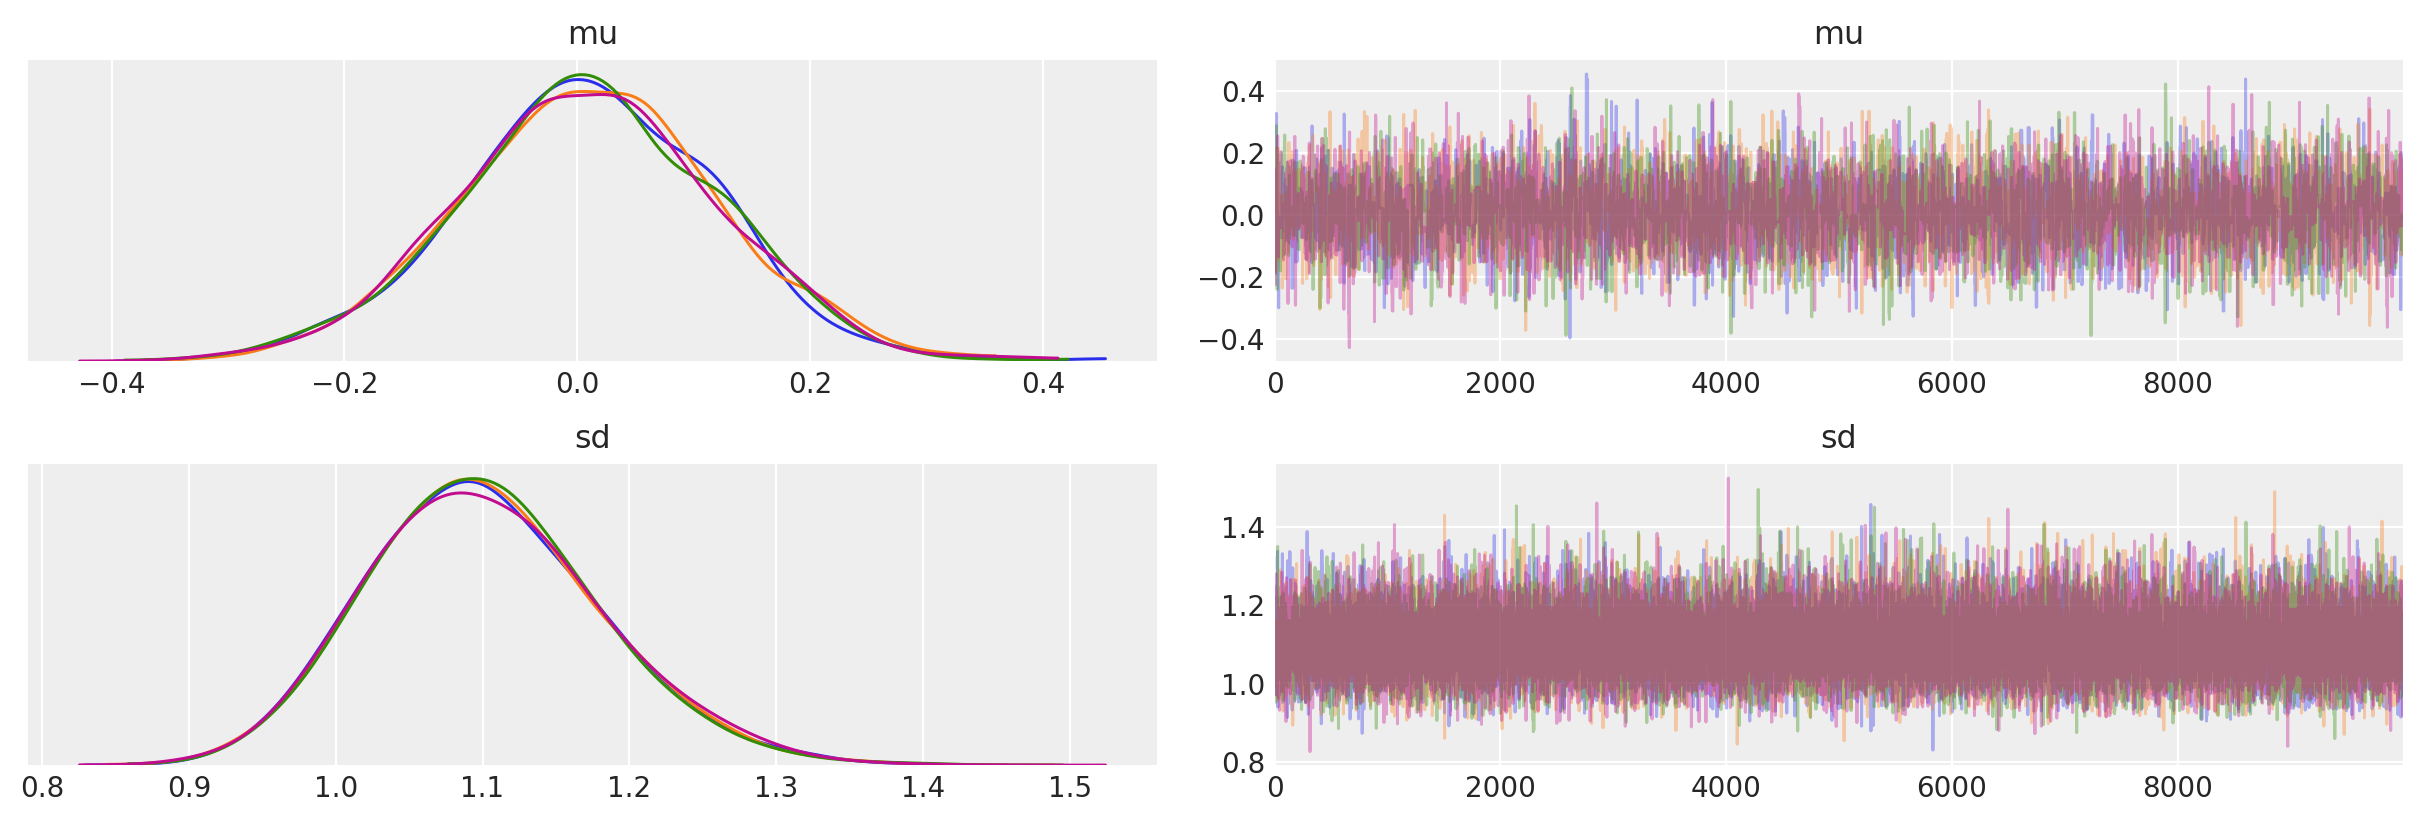

In [38]:
az.plot_trace(idata);

Another common metric to look at is R-hat, also known as the Gelman-Rubin statistic:

In [39]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.010,0.110,-0.187,0.227,0.001,0.001,6383.0,5438.0,6352.0,6807.0,1.0
sd,1.102,0.078,0.961,1.253,0.000,0.000,37700.0,37213.0,38198.0,29271.0,1.0


These are also part of the `forestplot`:

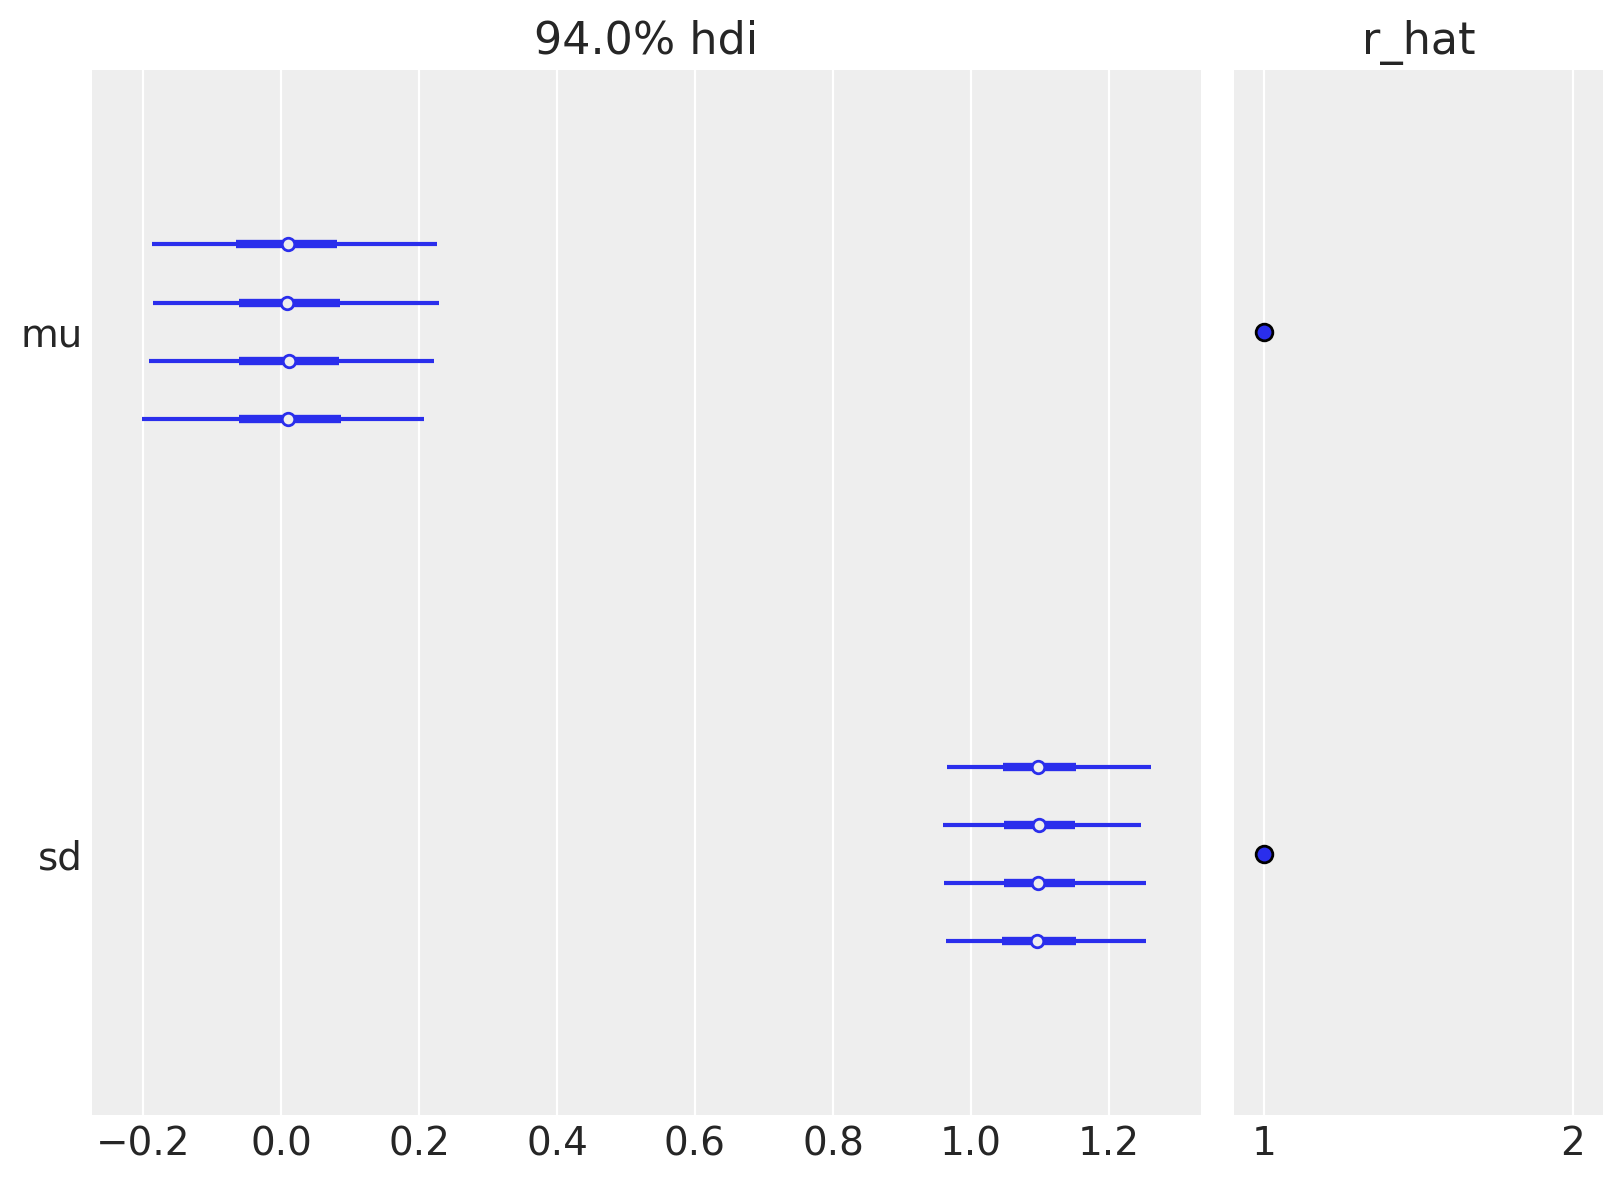

In [40]:
az.plot_forest(idata, r_hat=True);

Finally, for a plot of the posterior that is inspired by the book [Doing Bayesian Data Analysis](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/), you can use the:

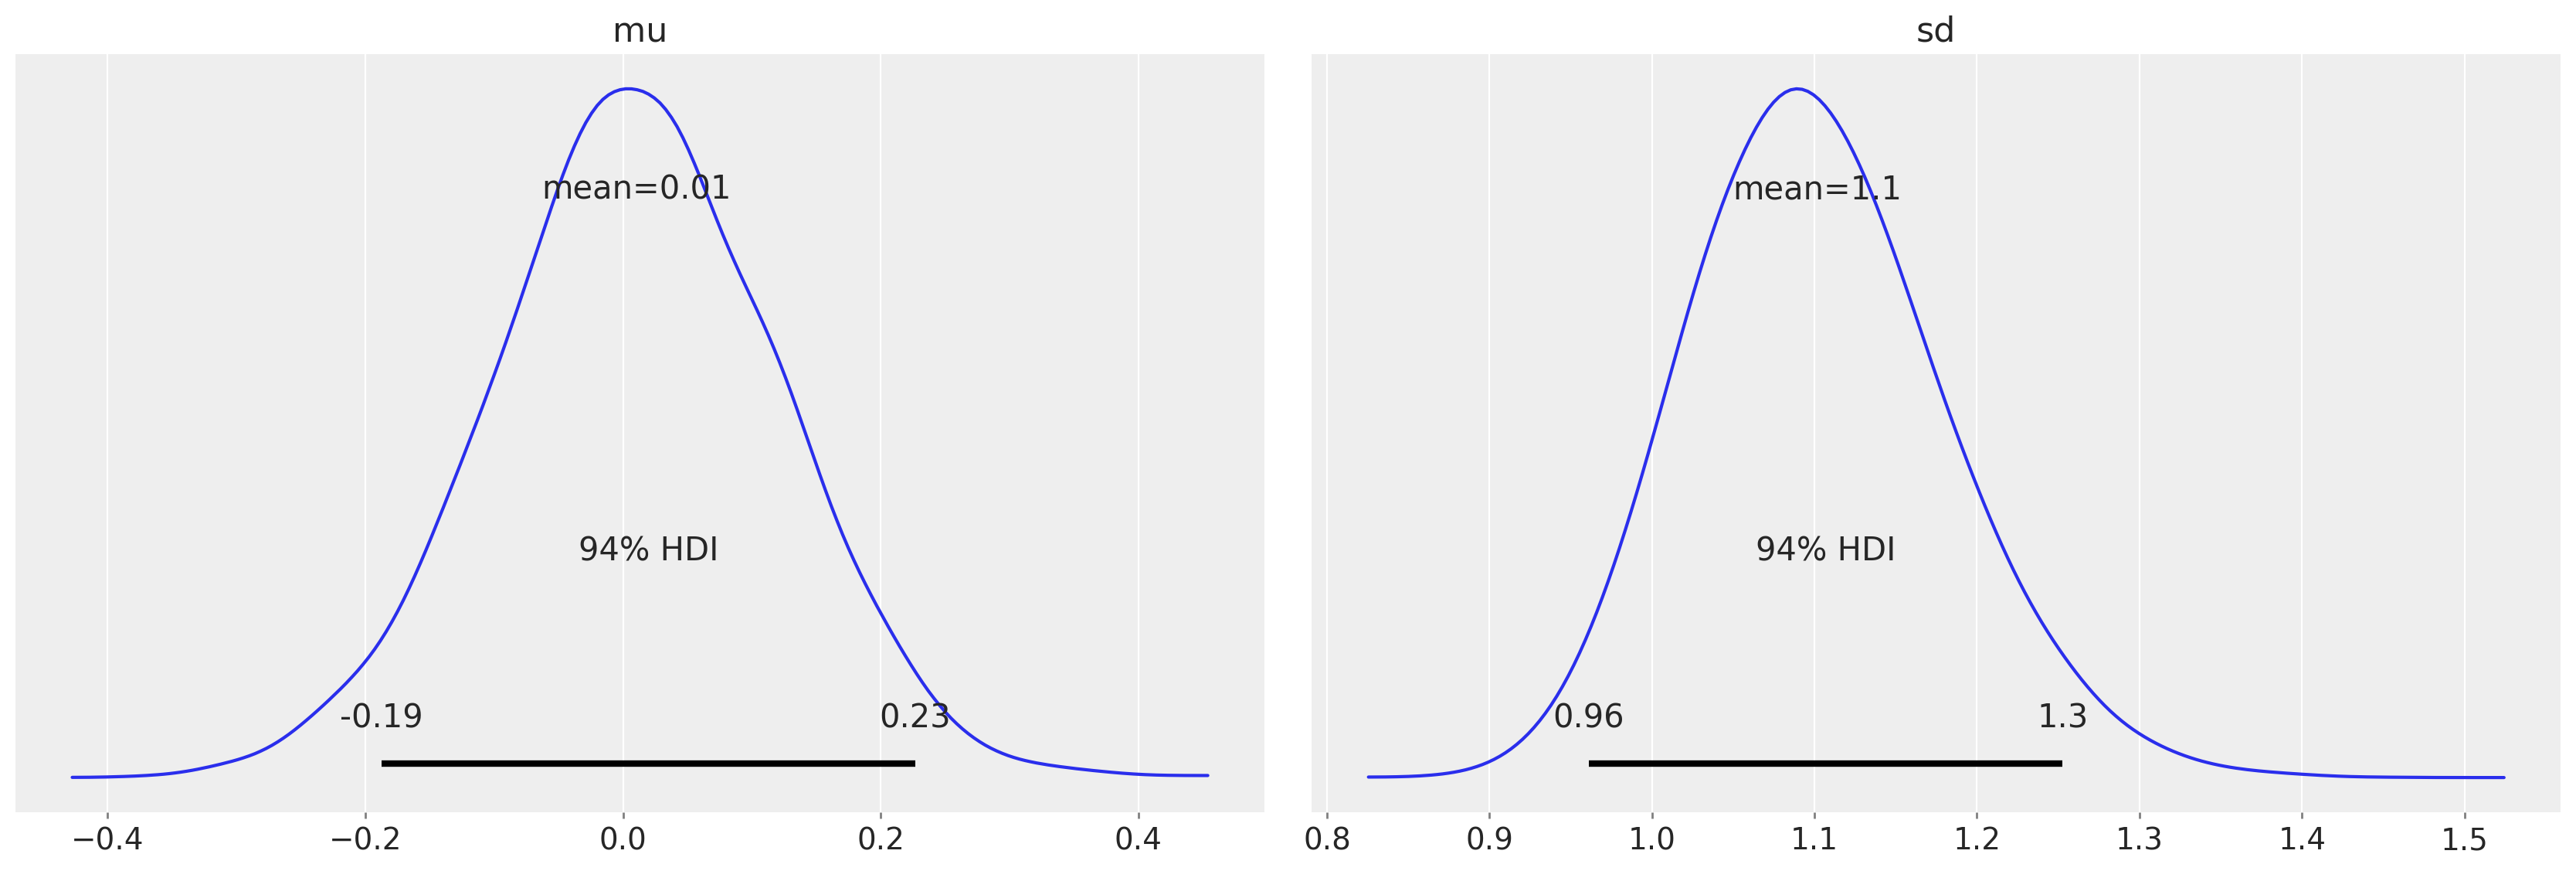

In [41]:
az.plot_posterior(idata);

For high-dimensional models it becomes cumbersome to look at all parameter's traces. When using `NUTS` we can look at the energy plot to assess problems of convergence:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


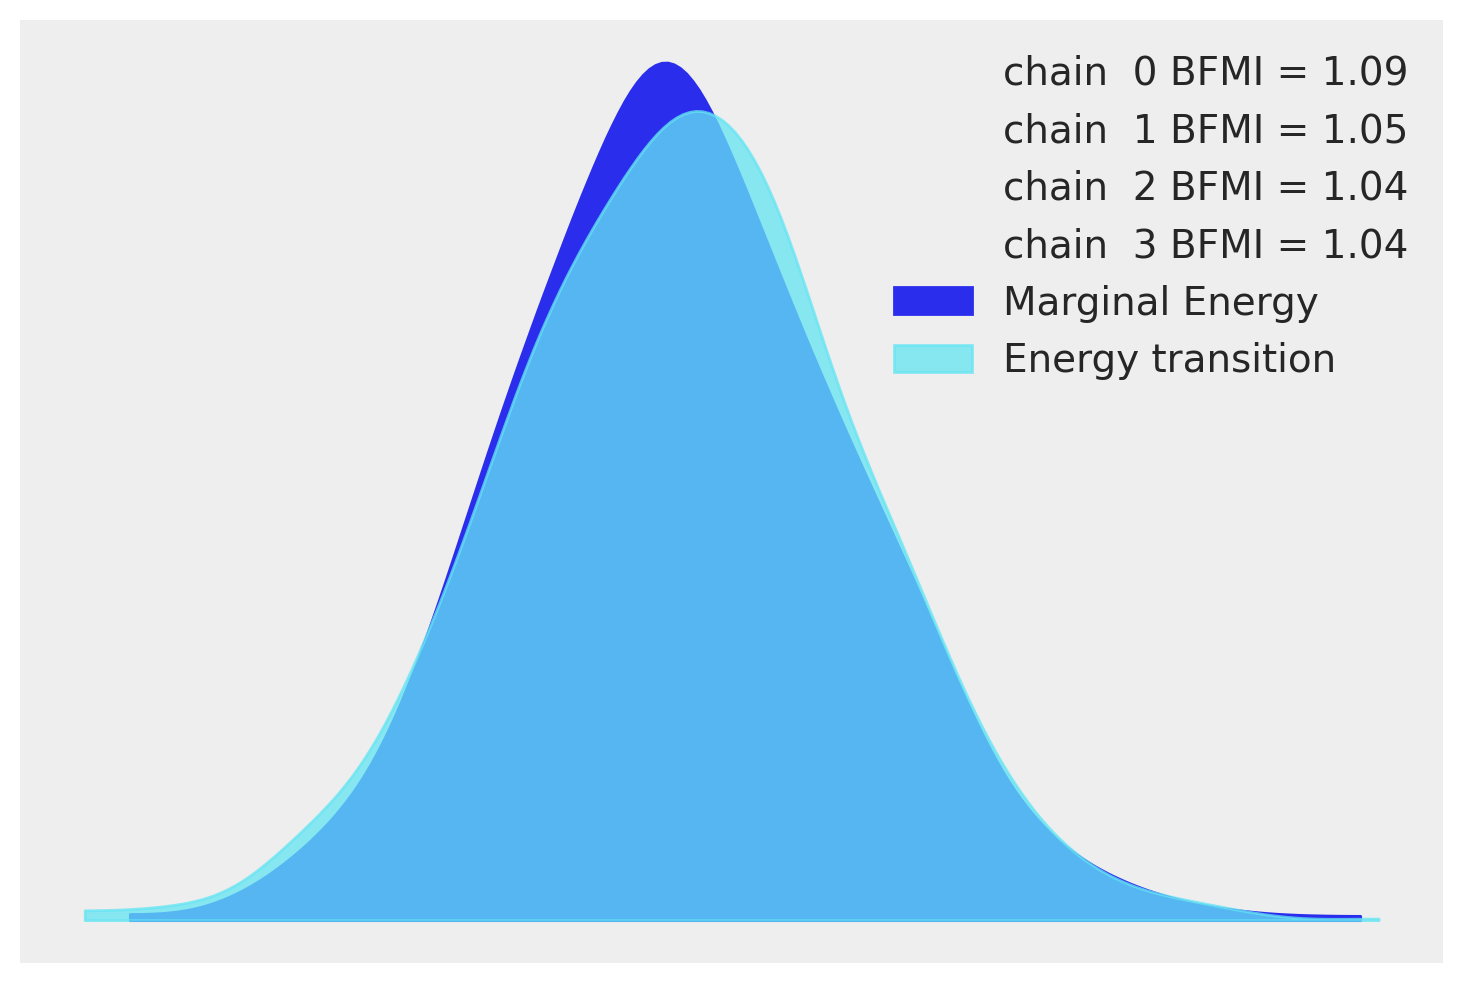

In [42]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1, shape=100)
    idata = pm.sample(cores=4, return_inferencedata=True)

az.plot_energy(idata);

For more information on sampler stats and the energy plot, see [here](sampler-stats.ipynb). For more information on identifying sampling problems and what to do about them, see [here](Diagnosing_biased_Inference_with_Divergences.ipynb).

### 3.3 Variational inference

PyMC3 supports various Variational Inference techniques. While these methods are much faster, they are often also less accurate and can lead to biased inference. The main entry point is `pymc3.fit()`.

In [43]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    approx = pm.fit()

Finished [100%]: Average Loss = 154.29


The returned `Approximation` object has various capabilities, like drawing samples from the approximated posterior, which we can analyse like a regular sampling run:

In [44]:
approx.sample(500)

<MultiTrace: 1 chains, 500 iterations, 3 variables>

The `variational` submodule offers a lot of flexibility in which VI to use and follows an object oriented design. For example, full-rank ADVI estimates a full covariance matrix:

In [45]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    approx = pm.fit(method="fullrank_advi")

Finished [100%]: Average Loss = 0.0065707


An equivalent expression using the object-oriented interface is:

In [46]:
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    approx = pm.FullRankADVI().fit()

Finished [100%]: Average Loss = 0.011343


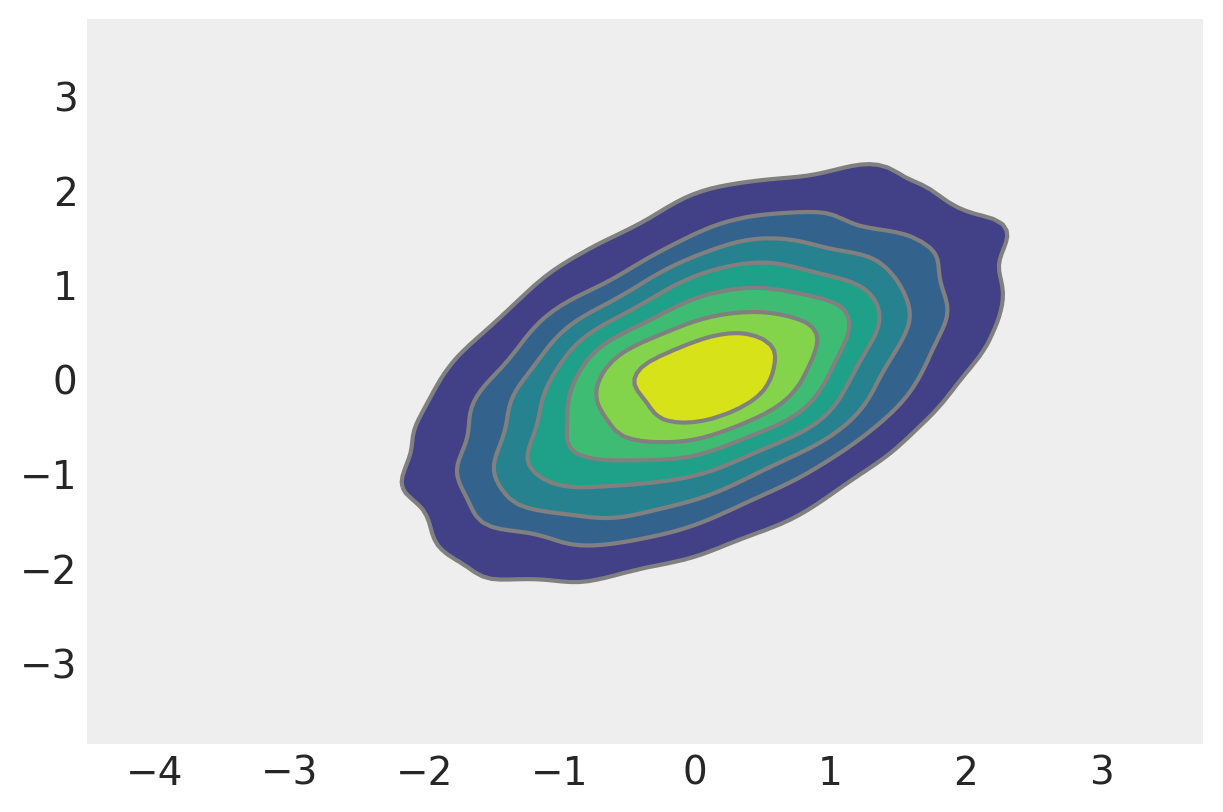

In [47]:
plt.figure()
trace = approx.sample(10000)
az.plot_kde(trace["x"][:, 0], trace["x"][:, 1]);

Stein Variational Gradient Descent (SVGD) uses particles to estimate the posterior:

In [48]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])
with pm.Model() as model:
    pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.0))

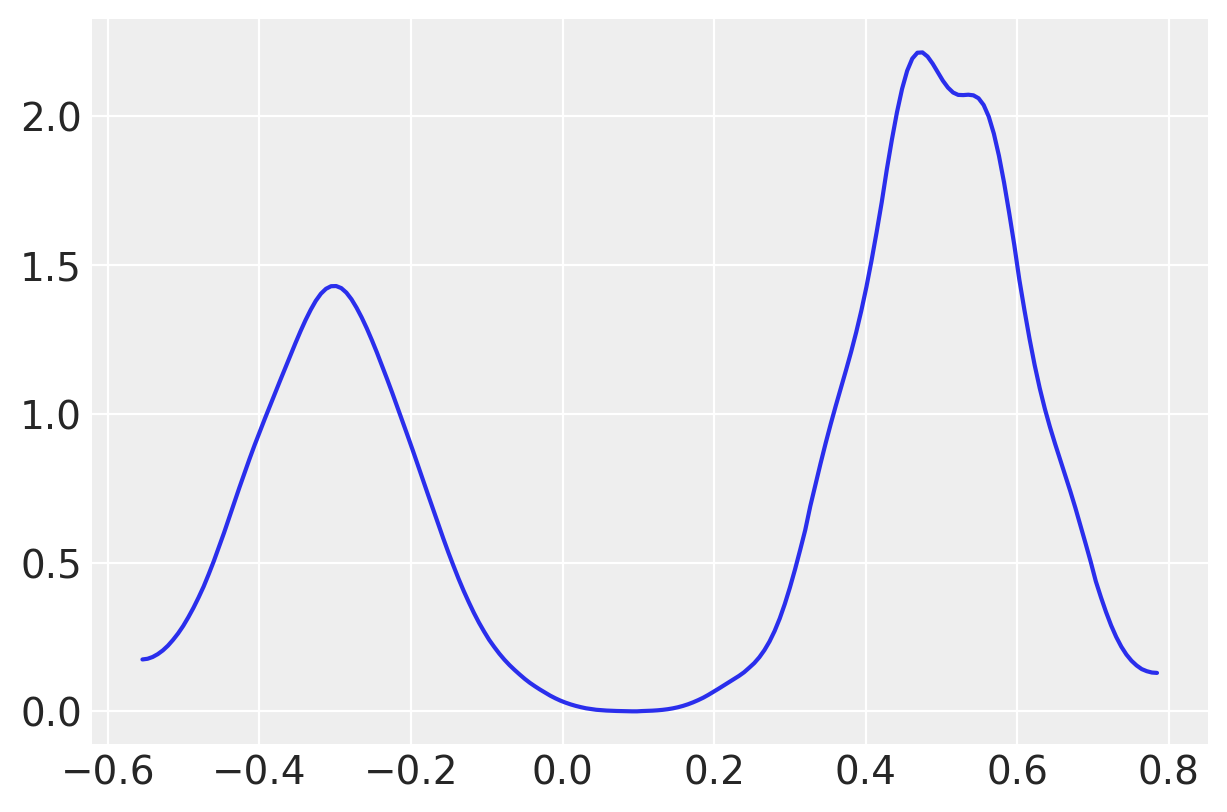

In [49]:
plt.figure()
trace = approx.sample(10000)
az.plot_dist(trace["x"]);

For more information on variational inference, see [these examples](http://pymc-devs.github.io/pymc3/examples.html#variational-inference).

## 4. Posterior Predictive Sampling

The `sample_posterior_predictive()` function performs prediction on hold-out data and posterior predictive checks.

In [50]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [51]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)
# add posterior predictive to the InferenceData
az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

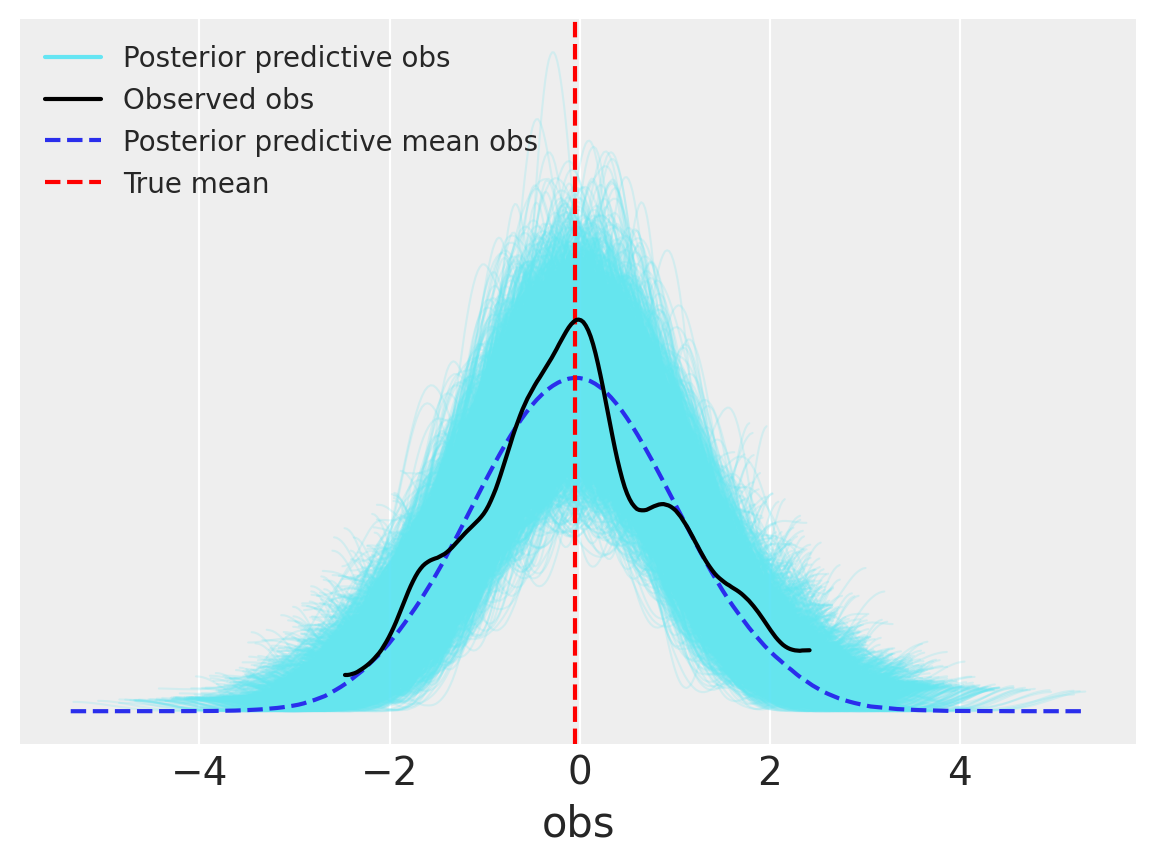

In [52]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

## 4.1 Predicting on hold-out data

In many cases you want to predict on unseen / hold-out data. This is especially relevant in Probabilistic Machine Learning and Bayesian Deep Learning. We recently improved the API in this regard with the `pm.Data` container. It is a wrapper around a `theano.shared` variable whose values can be changed later. Otherwise they can be passed into PyMC3 just like any other numpy array or tensor.

This distinction is significant since internally all models in PyMC3 are giant symbolic expressions. When you pass data directly into a model, you are giving Theano permission to treat this data as a constant and optimize it away as it sees fit. If you need to change this data later you might not have a way to point at it in the symbolic expression. Using `theano.shared` offers a way to point to a place in that symbolic expression, and change what is there.

In [53]:
x = np.random.randn(100)
y = x > 0

with pm.Model() as model:
    # create shared variables that can be changed later on
    x_shared = pm.Data("x_obs", x)
    y_shared = pm.Data("y_obs", y)

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli("obs", p=logistic, observed=y_shared)
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.879577618919674, but should be close to 0.8. Try to increase the number of tuning steps.


Now assume we want to predict on unseen data. For this we have to change the values of `x_shared` and `y_shared`. Theoretically we don't need to set `y_shared` as we want to predict it but it has to match the shape of `x_shared`.

In [54]:
with model:
    # change the value and shape of the data
    pm.set_data({
        "x_obs": [-1, 0, 1.0],
        # use dummy values with the same shape:
        "y_obs": [0, 0, 0],
    })

    post_pred = pm.sample_posterior_predictive(idata.posterior)

In [55]:
post_pred["obs"].mean(axis=0)

array([0.02075, 0.4965 , 0.9725 ])

In [56]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz 0.8.3
numpy 1.18.5
pymc3 3.9.0
last updated: Fri Jun 12 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
